<a href="https://colab.research.google.com/github/dohb128/SW2025/blob/main/SW25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


설정된 폰트 이름: NanumGothic


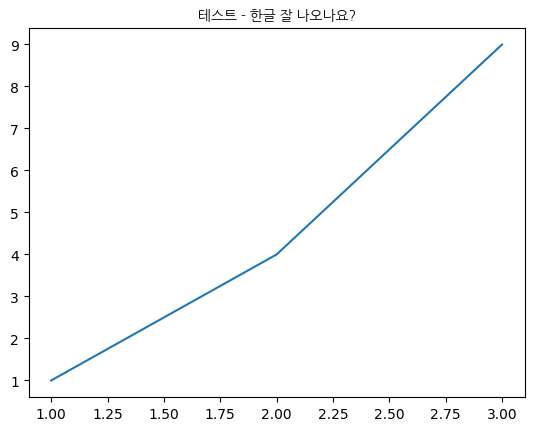

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum -qq

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
import matplotlib as mpl
import os

# 2. matplotlib 캐시 강제 삭제 (중요)
import shutil
matplotlib_cache_dir = mpl.get_cachedir()
if os.path.exists(matplotlib_cache_dir):
    shutil.rmtree(matplotlib_cache_dir)

# 설치된 나눔고딕 경로 가져오기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)

# 전역 설정
font_name = fontprop.get_name()  # 폰트 이름 가져오기
mpl.rcParams['font.family'] = font_name  # NanumGothic으로 확실하게 설정
plt.rcParams['axes.unicode_minus'] = False

# 확인
print("설정된 폰트 이름:", font_name)

plt.plot([1, 2, 3], [1, 4, 9])
plt.title("테스트 - 한글 잘 나오나요?", fontproperties=fontprop)
plt.show()

In [ ]:
# 시스템 명령어로 압축 해제 (한글 깨짐 방지)
!apt-get install -y unzip
!unzip -O cp949 '/content/drive/MyDrive/자료.zip' -d '/content/dataset'

^C
Archive:  /content/drive/MyDrive/자료.zip
replace /content/dataset/자료/결막염/crop_D0_034eae10-60a5-11ec-8402-0a7404972c70.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 🚀 Transfer Learning + Custom 강화 모델

# 기본 import
import os
import numpy as np
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# TensorFlow import
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 📂 파일 경로 설정
base_path = '/content/dataset/자료'

class_dirs = {
    '결막염': os.path.join(base_path, '결막염'),
    '백내장_무': os.path.join(base_path, '백내장', '무'),
    '백내장_비성숙': os.path.join(base_path, '백내장', '비성숙'),
    '백내장_성숙': os.path.join(base_path, '백내장', '성숙'),
    '백내장_초기': os.path.join(base_path, '백내장', '초기'),
    '색소침착성각막염': os.path.join(base_path, '색소침착성각막염'),
    '안검종양': os.path.join(base_path, '안검종양')
}

label_to_idx = {label: idx for idx, label in enumerate(class_dirs)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# 🎯 이미지 로드
images = []
labels = []
bbox_error_count = 0

random.seed(42)

for label_name, dir_path in class_dirs.items():
    json_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]
    selected_json_files = random.sample(json_files, min(len(json_files), 500))

    for filename in tqdm(selected_json_files, desc=f"Loading {label_name}"):
        json_path = os.path.join(dir_path, filename)
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_filename = 'crop_' + data['images']['meta']['file_name']
            image_path = os.path.join(dir_path, image_filename)
            if not os.path.exists(image_path):
                continue

            img = Image.open(image_path).convert('RGB')

            try:
                bbox = data['label']['label_bbox']
                x_min, y_min, x_max, y_max = map(int, bbox)
                cropped = img.crop((x_min, y_min, x_max, y_max)).resize((224, 224))
            except Exception:
                bbox_error_count += 1
                cropped = img.resize((224, 224))

            images.append(img_to_array(cropped))
            labels.append(label_to_idx[label_name])

        except Exception as e:
            print(f"⚠️ 오류 - {filename}: {e}")

print(f"\n⚡ bbox 에러로 전체 이미지 사용된 파일 수: {bbox_error_count}개")
print(f"✅ 최종 로딩된 이미지 수: {len(images)}개")
print("\n🚀 데이터 로드 완료. 이제 학습을 시작합니다...\n")

# 데이터 전처리
X = np.array(images, dtype='float32')
X = preprocess_input(X)  # MobileNetV2 전처리

y = to_categorical(labels, num_classes=len(label_to_idx))

# 데이터 분할
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=3/7, random_state=42, stratify=y_temp)

# 📚 MobileNetV2 기반 모델 만들기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Feature extractor로만 사용

x = base_model.output
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_to_idx), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️ 학습 시작
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=16
)

# 📈 테스트셋 평가
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 한글 폰트 설정 (NanumGothic 사용)
!apt-get install -y fonts-nanum
!fc-cache -fv
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 🔄 Confusion Matrix 출력
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(len(label_to_idx))],
            yticklabels=[idx_to_label[i] for i in range(len(label_to_idx))])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

# 🔄 Classification Report 출력
print("\n[Classification Report]")
print(classification_report(y_true, y_pred, target_names=[idx_to_label[i] for i in range(len(label_to_idx))]))



Loading 백내장_성숙:  81%|████████▏ | 407/500 [00:13<00:03, 27.44it/s]

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# --- 테스트 폴더 경로 ---
test_folder = '/content/dataset/자료/테스트'

# --- 파일 리스트 ---
test_images = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# --- 파일명 패턴을 실제 라벨로 매핑하는 함수 ---
def get_true_label_from_filename(filename):
    if filename.startswith('결유'):
        return '결막염_유'
    elif filename.startswith('백무'):
        return '백내장_무'
    elif filename.startswith('백초'):
        return '백내장_초기'
    elif filename.startswith('백비성'):
        return '백내장_비성숙'
    elif filename.startswith('백성'):
        return '백내장_성숙'
    elif filename.startswith('색소침착성각막염'):
        return '색소침착성각막염'
    elif filename.startswith('안검종양'):
        return '안검종양'
    else:
        return None  # 예외처리용

# --- 테스트 수행 ---
correct = 0
total = 0

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)

    # 이미지 로드 및 전처리
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # 모델 예측
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_label = idx_to_label[pred_class]

    # 실제 정답 추론
    true_label = get_true_label_from_filename(img_name)

    # 비교
    is_correct = (pred_label == true_label)
    if is_correct:
        correct += 1
    total += 1

    # 결과 출력
    result_text = "⭕ 정답" if is_correct else "❌ 오답"
    print(f"🖼️ 파일명: {img_name} → 예측: {pred_label} / 정답: {true_label} → {result_text}")

# --- 최종 정확도 출력 ---
accuracy = correct / total * 100
print(f"\n🎯 최종 테스트 정확도: {accuracy:.2f}% ({correct}/{total}개 맞춤)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🖼️ 파일명: 백초2.jpg → 예측: 색소침착성각막염 / 정답: 백내장_초기 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🖼️ 파일명: 결유1.jpg → 예측: 결막염 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🖼️ 파일명: 백무1.png → 예측: 백내장_무 / 정답: 백내장_무 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🖼️ 파일명: 결유2.jpg → 예측: 색소침착성각막염 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🖼️ 파일명: 색소침착성각막염4.jpg → 예측: 백내장_비성숙 / 정답: 색소침착성각막염 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🖼️ 파일명: 백무2.jpg → 예측: 백내장_무 / 정답: 백내장_무 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🖼️ 파일명: 백비성3.jpg → 예측: 안검종양 / 정답: 백내장_비성숙 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🖼️ 파일명: 결유4.jpg → 예측: 색소침착성각막염 / 정답: 결막염_유 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🖼️ 파일명: 색소침착성각막염5.jpg → 예측: 색소침착성각막염 / 정답: 색소침착성각막염 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🖼️ 파일명: 백성1.jpg → 예측: 색소침착성각막염 / 정답: 백내장_성숙 → ❌ 오답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🖼️ 파일명: 안검종양5.jpg → 예측: 안검종양 / 정답: 안검종양 → ⭕ 정답
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 